<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/new_similarity_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import external libraries

In [1]:
import hashlib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from google.colab import files
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


np.random.seed(42)
tf.random.set_seed(42)
random.seed(100)

# Import custom classes

In [2]:
class MinHash:
    def __init__(self, num_hashes=100):
        self.num_hashes = num_hashes
        self.seeds = [random.randint(0, 2**32 - 1) for _ in range(num_hashes)]

    def _hash(self, x, seed):
        return int(hashlib.md5((str(seed) + x).encode('utf8')).hexdigest(), 16)

    def compute(self, set_data):
        min_hashes = [min(self._hash(el, seed) for el in set_data) for seed in self.seeds]
        return min_hashes

    def jaccard_similarity(self, set1, set2):
        min_hash1 = self.compute(set1)
        min_hash2 = self.compute(set2)
        return sum(1 for a, b in zip(min_hash1, min_hash2) if a == b) / self.num_hashes


def hashing(str1, str2):

    n = 3
    set1 = {str1[i:i+n] for i in range(len(str1) - n + 1)}
    set2 = {str2[i:i+n] for i in range(len(str2) - n + 1)}
    minhash = MinHash(num_hashes=100)
    similarity = minhash.jaccard_similarity(set1, set2)
    return(1 - similarity)

def plot_distribution(data):
    if isinstance(data, list):
        data = np.array(data)

    plt.figure(figsize=(10, 6))

    sns.histplot(data, bins=30, kde=True, color='blue', alpha=0.6, stat='density')

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Numbers')

    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
  y_true = [0 if x < 0.5 else 1 for x in y_test]
  y_pred = [0 if x < 0.5 else 1 for x in model.predict(X_test)]

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

#Import databank from HDF format

In [3]:
from google.colab import drive
drive.mount('/content/drive')

databank = pd.read_hdf("/content/drive/MyDrive/databank_updated", key="databank")

df = databank.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import databank from pickeled file

In [ ]:
with open('/content/drive/MyDrive/databank.pkl', 'rb') as f:
    databank = pickle.load(f)

df = databank.copy()


<ipython-input-5-f4dd79abb425>:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


#Generate primary training dataset

In [5]:
id = []
sequence = []
cast = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
        if df['Uniprot ID'][i] != 'None':
            id.append(df['Uniprot ID'][i])
            sequence.append(df['sequence'][i])
            cast.append(df['cast spectra'][i])

ref_seq = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'

cast_flat = []
hash = []

for i in range(0, len(sequence)):
    cast_flat.append(cast[i])
    hash.append(hashing(sequence[i], ref_seq))

X = np.array(cast_flat)
y = np.array(hash)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

#Train primary algorithm

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.1698 - mae: 0.4001 - val_loss: 0.0786 - val_mae: 0.2141
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0717 - mae: 0.1879 - val_loss: 0.0623 - val_mae: 0.1391
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0593 - mae: 0.1339 - val_loss: 0.0547 - val_mae: 0.1256
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0523 - mae: 0.1232 - val_loss: 0.0470 - val_mae: 0.1181
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0447 - mae: 0.1146 - val_loss: 0.0387 - val_mae: 0.1074
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0359 - mae: 0.1032 - val_loss: 0.0297 - val_mae: 0.0961
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0260 - mae: 0.0901 - val_loss: 0.0226 - val_mae: 0.0804
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0179 - mae: 0.0735 - val_loss: 0.0181 - val_mae: 0.0669
Epoch 9/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0129 - mae: 0.0594 - 

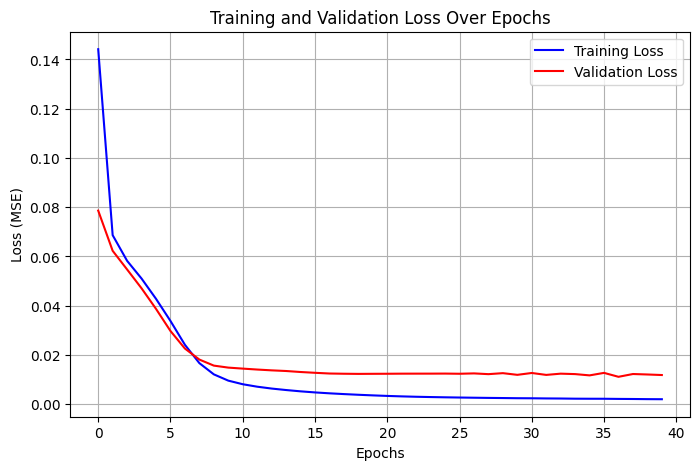

In [6]:

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(1600,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model and store training history
history = model.fit(X_train, y_train, epochs=40, batch_size=512, validation_split=0.2)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")

# 🎨 Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#Primary confusion matrix

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


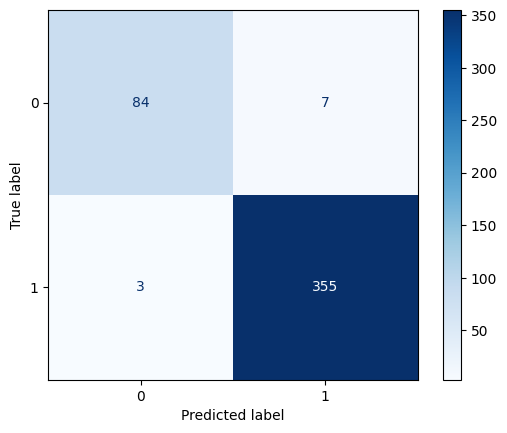

In [7]:


def plot_confusion_matrix(model, X_test, y_test):
    # Ensure y_test is binary (0 or 1)
    #y_test = np.array(y_test).astype(int)  # ✅ Convert to integer if needed
    y_test = np.where(np.array(y_test) > 0.5, 1, 0).astype(int)

    # Get model predictions
    y_scores = model.predict(X_test)

    # Convert predictions to binary labels
    y_pred = (y_scores >= 0.5).astype(int).flatten()  # ✅ Convert float → int

    # Ensure shapes match
    if y_test.shape != y_pred.shape:
        print(f"Shape mismatch: y_test {y_test.shape}, y_pred {y_pred.shape}")
        y_test = y_test.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Show the plot
    plt.show()

# Call the function
plot_confusion_matrix(model, X_test, y_test)

#Primary frequency distribution

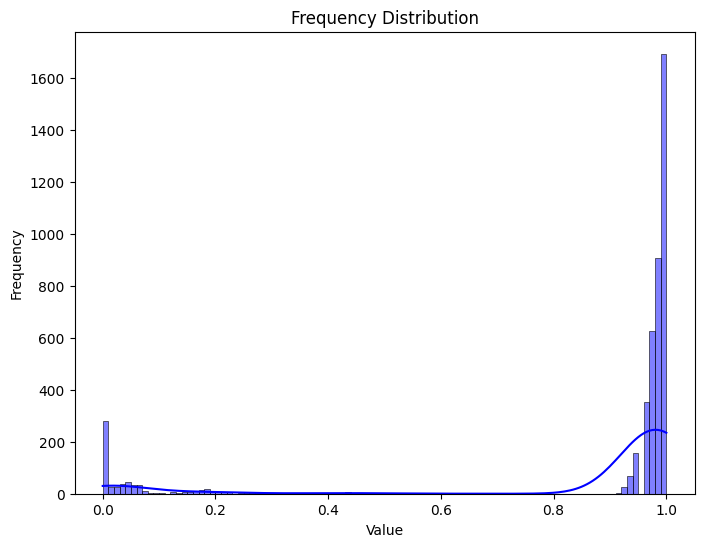

In [8]:
# Generate sample data
data = np.array(hash)  # Normally distributed data

# Plot the frequency distribution
plt.figure(figsize=(8, 6))
sns.histplot(data, bins=100, kde=True, color='blue', legend=False)

#plt.yscale('log', base=2)
# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')

# Show the plot
plt.show()


#Generate secondary training dataset

In [54]:

cast = []
mass = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
          cast.append(df['cast spectra'][i])
          mass.append(df['MASS'][i])

hash = model.predict(np.array(cast))

X = np.array(cast)
y = np.array(hash)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)


602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#Train secondary algorithm

In [10]:
for layer in model.layers:
        layer.trainable = False

    # Create a new Sequential model and add the old model as a base
new_model = tf.keras.Sequential([
        model,  # Include the original model
        tf.keras.layers.Dense(32, activation='relu', dtype='float16'),  # New layer
        tf.keras.layers.Dense(1, activation='sigmoid', dtype='float16')  # Output layer
    ])


new_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = new_model.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.2)

for layer in model.layers[-2:]:
        layer.trainable = True

# Recompile after unfreezing layers
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae'])

# Continue fine-tuning
history_finetune = new_model.fit(X_train, y_train, epochs=10, batch_size=512, validation_split=0.2)



Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1810 - mae: 0.4120 - val_loss: 0.1462 - val_mae: 0.3696
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1370 - mae: 0.3579 - val_loss: 0.1115 - val_mae: 0.3201
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1040 - mae: 0.3093 - val_loss: 0.0872 - val_mae: 0.2780
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0813 - mae: 0.2690 - val_loss: 0.0717 - val_mae: 0.2457
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0667 - mae: 0.2375 - val_loss: 0.0616 - val_mae: 0.2200
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0590 - mae: 0.2180 - val_loss: 0.0615 - val_mae: 0.2200
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0589 - mae: 0.2179 - val_loss: 0.0614 - val_mae: 0.2199
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0589 - mae: 0.2179 - val_loss: 0.0614 - val_mae: 0.2199
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0588 - m

#Confusion matrix for secondary algorithm

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape mismatch: y_test (1926, 1), y_pred (1926,)


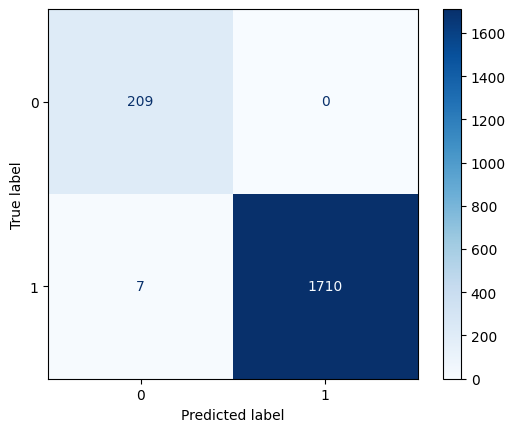

In [11]:
def plot_confusion_matrix(new_model, X_test, y_test):
    # Ensure y_test is binary (0 or 1)
    y_test = np.where(np.array(y_test) > 0.5, 1, 0).astype(int)

    # Get model predictions
    y_scores = new_model.predict(X_test)

    # Convert predictions to binary labels
    y_pred = (y_scores >= 0.69).astype(int).flatten()  # ✅ Convert float → int

    # Ensure shapes match
    if y_test.shape != y_pred.shape:
        print(f"Shape mismatch: y_test {y_test.shape}, y_pred {y_pred.shape}")
        y_test = y_test.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Show the plot
    plt.show()

# Call the function
plot_confusion_matrix(new_model, X_test, y_test)

#Frequency distribution for secondary algorithm

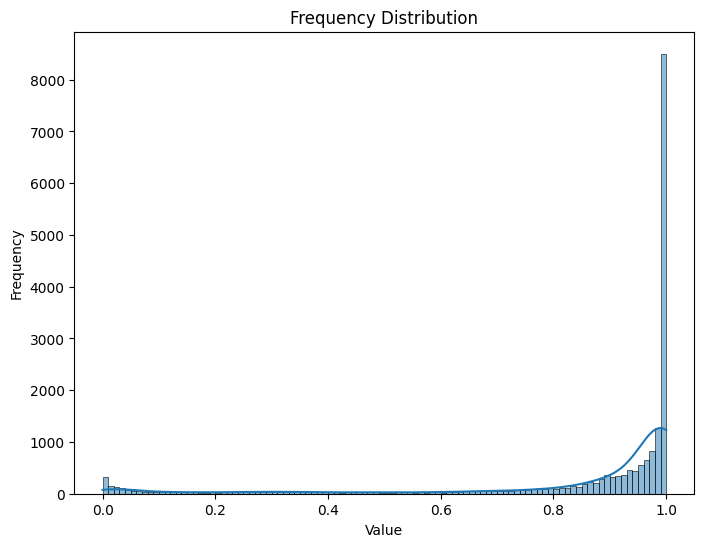

In [12]:
# Generate sample data
data = np.array(hash)  # Normally distributed data

# Plot the frequency distribution
plt.figure(figsize=(8, 6))
sns.histplot(data, bins=100, kde=True, color='blue', legend=False)

#plt.yscale('log', base=2)
# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')

# Show the plot
plt.show()


#Total number of identified alpha synuclein proteoform hits

In [33]:
cast = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
      if df['Uniprot ID'][i] == 'None':
          cast.append(df['cast spectra'][i])

hash = model.predict(np.array(cast))

a = 0
b = 0

for i in range(0, len(hash)):
  if hash[i] > 0.5:
    a += 1
  else:
    b += 1

print(a)
print(b)

462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
13047
1721


In [36]:
final_data = []

for i in range(0, len(hash)):
  if hash[i] < 0.5:
    final_data.append(cast[i])


In [38]:
len(final_data)

1721

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from google.colab import files

In [40]:
NAME = "Unsupervised_clustering"
tensorboard = TensorBoard(
    log_dir='/content/{}'.format(NAME))

In [41]:
len(final_data)

1721

In [42]:
n_dim = 1600
x_train = np.array(final_data)
y_train = np.zeros(1721)

In [43]:

latent_dim = 2

# Sampling layer for latent space
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Model for 1D input
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get the latent variables from the encoder
            z_mean, z_log_var, z = self.encoder(data)

            # Reconstruct the input from the latent space using the decoder
            reconstruction = self.decoder(z)

            # Compute reconstruction loss (binary crossentropy for 1D data)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )

            # Compute KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            # Total loss is the sum of reconstruction and KL loss
            total_loss = reconstruction_loss + kl_loss

        # Apply gradients to the model
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [44]:
def vae_training(random_seed):
  np.random.seed(random_seed)
  tf.random.set_seed(random_seed)
  encoder_inputs = keras.Input(shape=(n_dim,))
  x = layers.Dense(120 , activation="relu")(encoder_inputs)
  x = layers.Dense(120 , activation="relu")(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(n_dim, activation="relu")(latent_inputs)
  decoder_outputs = layers.Dense(n_dim, activation="sigmoid")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  vae = VAE(encoder, decoder)
  vae.compile(optimizer=keras.optimizers.Adam())
  history = vae.fit(x_train, epochs=50, callbacks=[tensorboard])
  loss = history.history['loss']
  return loss

In [45]:
vae_training(100)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - kl_loss: 0.0017 - loss: 0.4812 - reconstruction_loss: 0.4795
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - kl_loss: 3.1770e-04 - loss: 0.0709 - reconstruction_loss: 0.0705
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - kl_loss: 1.4901e-04 - loss: 0.0653 - reconstruction_loss: 0.0652
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - kl_loss: 2.1655e-04 - loss: 0.0649 - reconstruction_loss: 0.0647
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - kl_loss: 1.1885e-04 - loss: 0.0639 - reconstruction_loss: 0.0638
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - kl_loss: 7.0978e-05 - loss: 0.0631 - reconstruction_loss: 0.0630
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - kl_loss: 5.3137e-05 - loss: 0.0627 - reconstruction_loss: 0.0627
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - kl_loss: 6.0834e-05 - loss: 0.0624 - reconstruction_loss: 0.0623
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - kl_loss

[0.2975645065307617,
 0.06951364874839783,
 0.0659322440624237,
 0.06534290313720703,
 0.06438882648944855,
 0.06387954950332642,
 0.06378888338804245,
 0.06322964280843735,
 0.06294016540050507,
 0.0628696009516716,
 0.06309095025062561,
 0.06293906271457672,
 0.06278802454471588,
 0.06278744339942932,
 0.06284225732088089,
 0.0627087950706482,
 0.06273423135280609,
 0.06266003847122192,
 0.06270589679479599,
 0.06260719895362854,
 0.06265014410018921,
 0.06267459690570831,
 0.06264981627464294,
 0.0627107173204422,
 0.0626995861530304,
 0.06261836737394333,
 0.06271248310804367,
 0.06265359371900558,
 0.06262455135583878,
 0.0626676008105278,
 0.06270328164100647,
 0.06265798956155777,
 0.06268709152936935,
 0.06265991181135178,
 0.0627376064658165,
 0.06273213773965836,
 0.06268993020057678,
 0.06268114596605301,
 0.06267736107110977,
 0.06271428614854813,
 0.06274951249361038,
 0.0627472996711731,
 0.06277476996183395,
 0.06273994594812393,
 0.06272171437740326,
 0.0627703517675399

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)
encoder_inputs = keras.Input(shape=(n_dim,))
x = layers.Dense(120 , activation="relu")(encoder_inputs)
x = layers.Dense(120 , activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(n_dim, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(n_dim, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=5, callbacks=[tensorboard])


def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_train, y_train)

# Extract latent features
z_mean, z_log_var, z = encoder.predict(x_train, batch_size=128)

# Use z_mean or z (you can experiment)
latent_features = z_mean  # shape: (num_samples, latent_dim)

In [56]:
len(mass)

19253